# IXP as-path is increasing on IXPs?
Graph IXP routing tables analysing number of received prepends

<pre>
obs: We also can use "edit" distance 
    https://www.merit.edu/wp-content/uploads/2016/01/Analyzing_BGP_ASPATH.pdf
    https://sites.google.com/site/amitsciscozone/networking-datascience/analyzing-bgp-as_path-behaviour-using-python
</pre>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly 
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import HTML
from IPython.display import display
import os
import re
import glob
import fnmatch
from datetime import date, datetime

import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from pandarallel import pandarallel
import argparse
import sys

# Globals

In [2]:
# Download routing tables to this folder
BGP_DATA  = "/Users/bertholdo/tmp/Routing_Tables/"      
# Output images 
#IMAGE_DIR = "/Users/bertholdo/PAPERS/asym/leandro/"
IMAGE_DIR = "./FIG/"

# in/out datasets
DATASET   = "/Users/bertholdo/ut_gitlab/asy_pathsize/dataset/"

version='1.10'

#List of banned ASes
#as_ban=pd.read_csv('results/comm-ban-list.csv', dtype=str)['ASN'].to_list()
as_ban=['2914', '1299', '3257', '3356', '174', '7922', '63956', '3491', '2516', 
        '9318', '2603', '9957', '7473', '6939', '1103', '2603', '20562', '1239', 
        '3257', '2914', '6461', '6939', '1251', '20080', '264575', '262605', '20473']

# Functions

In [3]:
def is_jupyter_notebook():
    ''' Return True if is running inside Jupyter Notebook or Jupyter lab '''
    try:
        __IPYTHON__
        _in_ipython_session = True
    except NameError:
        _in_ipython_session = False
    return _in_ipython_session

In [4]:
def tem_prepend (aspath):
    ''' Return True if there is any prepend on aspath False otherwise'''
    lst=str(aspath).split()
    return any(i==j for i,j in zip(lst, lst[1:]))

In [5]:
def qt_origin_prepend (aspath):
    ''' Return the number of prepends inserted at ORIGIN_AS'''
    lst=str(aspath).split()
    return (lst.count(str(lst[-1]))-1)

In [6]:
def qt_nei_prepend (aspath):
    ''' Return number of prepends added by NEIGHBOR_AS'''
    '''prepends added by ixp customer '''
    lst=str(aspath).split()
    return (lst.count(str(lst[0]))-1)

In [7]:
def countips(netblock):
    cidr = int(netblock.split('/')[1])
    return 2**(32 - cidr)

In [8]:
from pandas.errors import EmptyDataError

def load_ixp(ixp, option=None, max_samples=10):
    """ Load ixp datasets from BGP_DATA folder, add prepend informations and return
    a dataframe (df_all) with the full year regarding that ixp
    return a dataframe with IXP data
    recv: 
        ixp = one of ['amsix','spoixbr','six','auix','linx','decix','poaixbr']
        option = all/None/best (keep just one path by each prefix - pick the shortest as-path)
                 open (just neigbors up/open as listed in peerinfo)
                 ban (exclude banned aslist to match ingress asym - case of HE)
                 6939 (select just prefixes from huricane eletric)                 
    """
    ixp_asn_lst=[]
    req_cols=['NETWORK','AS_PATH','as_neigh','as_origin']
    file_selection=glob.glob(BGP_DATA + '*rtable_*_'+ixp+'.csv.gz')
    
    tot=len(file_selection)
    if tot<1:
        print('ERROR:: Something Wrong: NO FILES TO ANALYSE ',file_selection)
        raise KeyboardInterrupt
    
    c=0
    df_all=pd.DataFrame()
    print (f'Loading files for {ixp.upper()} on {BGP_DATA}')
    for f in file_selection:   
        
        if max_samples!=0 and c>=max_samples and is_jupyter_notebook():
            break
        c=c+1
        if (not (c%10)) or c==tot:
            sys.stdout.write(f'{c}/{tot}')
        else:
            sys.stdout.write('.')
        sys.stdout.flush()    
        try:
            df = pd.read_csv(f, usecols=req_cols, dtype=str)
        except EmptyDataError:
            print (f'ERROR:: File is empty? [{f}]')
            continue

        day=os.path.basename(f).split('_')[0]
        
        #
        # Select just Huricane Eletric
        if '6939' in option:
            df=df[df['as_neigh']=='6939']

        #
        # Remove neighbor routes from our BAN_COMM_LIST
        if 'ban' in option: 
            df=df[~df['as_neigh'].isin(as_ban)]                       
            
        #
        # Select just directed connected as in peerinfo files
        if 'open' in option:
            for f in glob.glob(f'peerinfo/*_{ixp}.csv.gz'):
                df_asnlst=pd.read_csv(f, dtype=str)
                df_asnlst = df_asnlst[(df_asnlst['policy'].str.upper()=='OPEN') & (df_asnlst['state'].str.upper()=='UP')]
                ixp_asn_lst = df_asnlst['ASN'].unique().tolist()
            df=df[df['as_neigh'].isin(ixp_asn_lst)]
                        
        df['date']=day
        df_all=pd.concat([df_all, df])

    print('\tDone!')
    df_all['date']=pd.to_datetime(df_all['date'])

    print ('\tStep1:Calc as_path_len')
    df_all['as_path_len']=df_all['AS_PATH'].parallel_apply(lambda x: len(str(x).split()))

    # Depending the routing table source (multiple Route-servers) we need to pick one as best prefix path
    # we orderer by smallest path size and pick the first (Alice, Bird)
    # as we are just considering as-path size that is enough.
    #if 'best' in option:
    print ('\tChosing the best as-path to count prepends...')
    df_all=df_all.sort_values('as_path_len', ascending=True)
    df_all=df_all.drop_duplicates(subset=['NETWORK','date'], keep='first')
    
    print ('\tStep2:Verifying any_prepend')
    df_all['any_prepend']=df_all['AS_PATH'].parallel_apply(tem_prepend)
    print ('\tStep3:Verifying nei_prepend')
    df_all['nei_prepend']=df_all['AS_PATH'].parallel_apply(qt_nei_prepend)
    print ('\tStep4:Verifying origin_prepend')
    df_all['origin_prepend']=df_all['AS_PATH'].parallel_apply(qt_origin_prepend)    

    return df_all

In [9]:
'''Shows the effect of HE (AS6939) on IXPs routing table'''

def gen_6939_graphs(ixp, sample=10, labely=True, legend='free'):
    dbest=gen_ONE_ixp_prepend_dataframe(ixp, 'best', sample)
    d69=gen_ONE_ixp_prepend_dataframe(ixp, '6939', sample)

    dbest=dbest[['day','tot_paths','any_prep_path']]
    rename_col={'tot_paths': 'Total paths',
                'any_prep_path':'Any prepend', 
                'origin_prep': 'Prepend at origin ASes',
                'nei_prep_all':'Prepends inserted by customer', 
                'nei_prep_client':'Customer prepending client prefixes', 
                'nei_prep_origin':'Customer prepending own prefixes' }  
    dbest=dbest.rename(columns=rename_col)

    d69=d69[['day','tot_paths','any_prep_path']]
    rename_col={'tot_paths': 'Total AS6939 paths',
                'any_prep_path':'AS6939 clients prepend', 
                'origin_prep': 'origin_prep_6939',
                'nei_prep_all':'nei_prep_all_6939', 
                'nei_prep_client':'nei_prep_client_6939', 
                'nei_prep_origin':'nei_prep_origin_6939' } 
    d69=d69.rename(columns=rename_col)
    
    
    dbest=dbest.set_index('day')
    d69=d69.set_index('day')
    df=pd.concat([dbest,d69], join='outer', axis=1)
    
    df=df.reset_index()
    df['day']=pd.to_datetime(df['day'])
    df=df.set_index('day')
    
    #return df
    #tidy=df.stack().reset_index().rename(columns={"level_1":"prepend_type", 0: "prefixes"})
    ax=df.plot.area( y=['Total paths', 'Total AS6939 paths', 'Any prepend', 'AS6939 clients prepend'], stacked=False)
    plt.title('AS6939 influency on '+ixp.upper())
    ax.set_xlabel('')
    
    if labely:
        plt.ylabel('Prefixes')   
    else:
        plt.ylabel('')
    plt.xlabel('')
    plt.title('')
    
    #
    # Force color=black for thesis print version
    #
    if legend==False:
        ax.get_legend().remove()
    elif legend!='free':
        leg=plt.legend(loc=legend)
        # Change the color of each text in the legend
        for text in leg.get_texts():
            text.set_color('black')  # Change to the color you want      
    
    # Change the color of x and y axis labels - forcing collor to fix book printing
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    # Change color of axis
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    # Change the color of tick labels
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

 


    # save image
    outfig=IMAGE_DIR+ixp+'_as6939.pdf'
    print(f'Figure saved at {outfig}')
    if (is_jupyter_notebook()):
        plt.savefig(outfig,bbox_inches='tight')
        plt.show()
    else:
        plt.savefig(outfig,bbox_inches='tight')
        plt.close()
        

# Who is prepending and how much?
<pre>
1) for prepends added to IXP path:        AMSIX:[5.61%]  AUIX:[2.56%] POAIXBR:[3.16%]  LINX:[7.99%]  SPOIXBR:[2.39%]  SIX:[4.86%]
2) for any prepended path received on IX: AMSIX:[26.81%] AUIX:[27.5%] POAIXBR:[31.59%] LINX:[32.62%] SPOIXBR:[26.47%] SIX:[32.49%] 
3) prepends for its own prefixes: 

Takeaway: 26-32% of all prefixes received at the IXP are prendended. 
The IXP customer is responsible for adding 23% of all those prefixes.
They prepend its client prefixes, but not their own.
</pre>

In [10]:
def who_is_prepending(ixp, df_all):
    '''generate a daily summary of who is prepending at one IXP
    '''
    day_lst = df_all['date'].drop_duplicates().dt.strftime('%Y-%m-%d').to_list()
    df_sum=pd.DataFrame()
    for day in day_lst:
        # for one day in the ixp life
        df=df_all[df_all['date']==day]
        
        #
        # Totals
        #
        #total paths 
        tot_paths=len(df)
        # path with some prepend everywhere
        any_prep_path=len(df[df['any_prepend']==True])
        # paths prepended at origin (any)
        origin_prep=len(df[df['origin_prepend']>0])
        # total paths originated on ixp's customer (his own prefixes)
        tot_origin_customer=len(df[ (df['as_neigh']==(df['as_origin'])) ])  

        #
        # prepends added by ixp's customers
        #       
        # all path prepended by ixp neighbor (directed connected to ixp)
        nei_prep_all    = len(df[df['nei_prepend']>0])
        # neighbor prepending its own prefixes
        nei_prep_origin = len(df[ (df['as_neigh']==(df['as_origin'])) & (df['nei_prepend']>0) ])       
        # neighbor prepending prefixes from another AS
        nei_prep_client = len(df[ (df['nei_prepend']>0) & (df['as_neigh']!=(df['as_origin'])) ])
        
        psource={'day':day,
                 'ixp':ixp,
                 'tot_paths':tot_paths, 
                 #
                 'any_prep_path':any_prep_path,
                 'origin_prep':origin_prep,
                 'tot_origin_customer':tot_origin_customer,
                 'nei_prep_all':nei_prep_all,
                 'nei_prep_origin':nei_prep_origin,
                 'nei_prep_client':nei_prep_client,
                 # mind zero division (and+or)
                 'perc_any_prep_path':round((tot_paths and any_prep_path/tot_paths or 0) *100,2) or 0,
                 'perc_origin_prep':round( (tot_paths and origin_prep/tot_paths or 0) *100,2) or 0,
                 'perc_origin_customer':round( (tot_paths and tot_origin_customer/tot_paths or 0) *100,2),
                 'perc_nei_prep_origin':round( (tot_origin_customer and nei_prep_origin/tot_origin_customer or 0) *100,2),  # how much ixp neighbor are prepending its own prefixes.
                 'perc_nei_prep_client':round( (any_prep_path and nei_prep_client/any_prep_path or 0) *100,2),      # how much they are prepending other ASes
                }    
        #df_sum=df_sum.append(psource, ignore_index=True)
        df_sum = pd.concat([ df_sum, pd.DataFrame.from_records([psource]) ])
        
        
    return df_sum

In [11]:
def gen_ONE_ixp_prepend_dataframe( ixp , option, sample):
    ''' Inspect all Routing_Table directory looking for IXPs in IXP_LIST.
        Process AS_PATH to extract PREPEND information from each Routing Table.
        Generate an entry (row) for each ixp/rtable day found.
        RETURN a dataframe with this information:
        
        ['day', 'ixp', 'tot_paths', 'any_prep_path', 'origin_prep',
       'tot_origin_customer', 'nei_prep_all', 'nei_prep_origin',
       'nei_prep_client', 'perc_any_prep_path', 'perc_origin_prep',
       'perc_origin_customer', 'perc_nei_prep_origin', 'perc_nei_prep_client']
       
       recv: ixp name and option as described in load_ixp
    '''
    fname=f'{DATASET}/{ixp}_{option}_{sample}_prepend.csv'
    # comment bellow to always generate all prepend csv
    if os.path.exists(fname):
        print(f'WARNING: Skipping [{ixp}]... Remove file [{fname}] to rebuild!')
        print(f'Reading dataframe from file [{fname}]')
        return pd.read_csv(fname)

    # load Routing_Table
    df=load_ixp(ixp, option, sample)  #0=use all tables    
    # count who is prepending
    dsum=who_is_prepending(ixp, df)   
    dsum=dsum.sort_values(by=['day','ixp'], ascending=False).reset_index(drop=True)
    # save file
    if not os.path.exists(DATASET):
        os.makedirs(DATASET)
    dsum.to_csv(fname, index=False)
    return dsum

# Number of Customer prepends on IXPs 
<pre>
 Directed conected ASes (customers) are depreferring IXP path?
     R: AMSIX customers have signicative variance, with a mean around 1.8 prepends by prefix. 
     After march 2022 went up almost reaching a mean of 2 prepends by each prefix announcement by customers. 
</pre>

In [12]:
import matplotlib 
def graph_who_is_prepending(ixp, option, sample):
    '''Graph who is prepending and save to IMAGES_DIR'''
    df=gen_ONE_ixp_prepend_dataframe(ixp, option, sample)

    #df=df[['day','tot_paths','any_prep_path','origin_prep','nei_prep_all','nei_prep_client','nei_prep_origin']]
    df=df[['day','any_prep_path','origin_prep','nei_prep_client','nei_prep_origin']]
    df['day']=pd.to_datetime(df['day'])
    df=df.set_index('day')
    #display(data.head(2))

    tidy=df.stack().reset_index().rename(columns={"level_1":"prepend_type", 0: "prefixes"})
    rename_col={'tot_paths': 'Total paths',
                'any_prep_path':'Any prepend', 
                'origin_prep': 'Origin prepend',
                'nei_prep_all':'Neighbor inserted prepend', 
                'nei_prep_client':'Neighbor prepending client', 
                'nei_prep_origin':'Neighbor prepending itself' }  
    tidy=tidy.replace({'prepend_type': rename_col})
    #display(tidy.head(2))

    #tidy
    fig=plt.figure(figsize=(12,4))
    sns.set(font_scale = 1.2)
    sns.set_style("whitegrid")
    ax=sns.lineplot(data=tidy, x='day', y="prefixes", hue='prepend_type').set(title='Prepended paths on '+ixp.upper())
    
    # Change axis and label colors for printing in black
    ax = plt.gca()  # get current axis
    ax.set_xlabel('Day', color='black')
    ax.set_ylabel('Prepended Paths', color='black')
    ax.tick_params(axis='both', colors='black')    
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    
    
    plt.xlabel('')
    plt.title('')
    plt.ylabel('Prepended Paths')
    plt.xticks(rotation = 25)
    #legend
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)
    #plt.legend(bbox_to_anchor=(0,1.02,1,0.2), bbox_transform=fig.transFigure, 
    #           loc="lower right",mode="expand", borderaxespad=0, ncol=4)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    # Change legend text color for printing in black
    leg = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)
    for text in leg.get_texts():
        text.set_color("black")
    
   
    outfig=IMAGE_DIR+ixp+'_'+option+'_who_is_prepending.pdf'
    print(f'Figure saved at {outfig}')
    if (is_jupyter_notebook()):
        plt.savefig(outfig,bbox_inches='tight',pad_inches = 0)
        plt.show()
    else:
        plt.savefig(outfig,bbox_inches='tight',pad_inches = 0)
        plt.close()

## MEDIAN AS-path size seen on IXP
<pre>
 The IXP average as-path is growing? 
     R: AMSIX-The number of prefixes annouced on IXPs have slightly grew, and the number of prepended paths sligtly diminished.
</pre>

In [51]:
def graph_prepend_noprepend_best(ixp, option, sample, labely=True, legend='free'):
    '''Graph prepended and not prepended paths for the BEST PATH found
    and save to IMAGES_DIR'''
    df=gen_ONE_ixp_prepend_dataframe(ixp, option, sample)

    #df=df[['day','tot_paths','any_prep_path','origin_prep','nei_prep_all','nei_prep_client','nei_prep_origin']]
    df=df[['day','tot_paths','any_prep_path']]
    df['day']=pd.to_datetime(df['day'])
    
    # prepare plot
    rename_col={'day':'Date',
                'tot_paths': 'Regular AS-path',
                'any_prep_path':'Prepended AS-path'}  
    data=df.rename(columns=rename_col)
    data=data.set_index('Date')
    #display(data.head(2))

    # Plot prepended vs not prepended path on ixp
    fig=plt.figure(figsize=(12,4))
    sns.set(font_scale = 1.2)
    sns.set_style("whitegrid")    
    ax=data.plot.area( y=['Regular AS-path','Prepended AS-path'], stacked=False)
    plt.title('Evaluating prepended announcements on '+ixp.upper())

    if labely:
        plt.ylabel('Prefixes')   
    else:
        plt.ylabel('')
    plt.xlabel('')
    plt.title('')

        
    #
    # Force color=black for thesis print version
    #
    if legend==False:
        ax.get_legend().remove()
    elif legend!='free':
        leg=plt.legend(loc=legend)
        # Change the color of each text in the legend
        for text in leg.get_texts():
            text.set_color('black')  # Change to the color you want      
    
    # Change the color of x and y axis labels - forcing collor to fix book printing
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    # Change color of axis
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    # Change the color of tick labels
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')     
        
    print (legend)

    plt.xticks(rotation = 25)

    outfig=IMAGE_DIR+ixp+'_'+option+'_prepend_vs_notprepend.pdf'
    print(f'Figure saved at {outfig}')
    if (is_jupyter_notebook()):
        leg=plt.legend(loc=legend)
        fig.canvas.draw()
        plt.savefig(outfig,bbox_inches='tight',pad_inches = 0, bbox_extra_artists=(leg,))
        plt.show()
    else:
        plt.savefig(outfig,bbox_inches='tight',pad_inches = 0, bbox_extra_artists=(legend,))
        plt.close()

Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//linx_best_0_prepend.csv]
center right
Figure saved at ./FIG/linx_best_prepend_vs_notprepend.pdf


<Figure size 864x288 with 0 Axes>

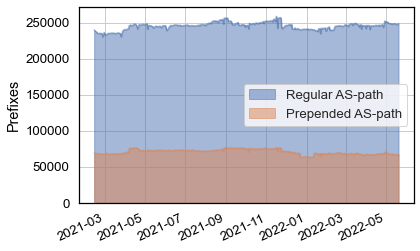

In [55]:
graph_prepend_noprepend_best('linx', 'best', 0, True, 'center right')

In [14]:
def OLD_prepend_vs_notprepend(df_all):
    '''
    Process ixp_prepend dataframe for all dates and graph 
    PREPENDED vs. NOT_PREPENDED paths for all paths received
    on route-server. Not just the best.
    '''
# prepare plot
    df=df_all
    df=df[['date','NETWORK','any_prep_path']]
    df=df.groupby(['date','any_prep_path']).count()
    df=df.reset_index().copy()
    
    d2=df[df['any_prep_path']==True][['date','NETWORK']] 
    d1=df[df['any_prep_path']==False][['date','NETWORK']] 
    d2.columns=['Date','Prepended AS-path']
    d1.columns=['Date','Regular AS-path']
    
    df=pd.merge(d1,d2, on='Date').set_index('Date')
    df['Total Paths']=df['Regular AS-path']+df['Prepended AS-path']
    df['Percentual']=df['Prepended AS-path']/df['Total Paths']*100
    
    # Summarize all period
    df_summary=df.reset_index().copy()
    print("===> Any Prepended Paths on {} :: MIN:{}%  MAX:{}%  MEAN:{}%".format(
          ixp.upper(), 
          round(df_summary['Percentual'].min(),2), 
          round(df_summary['Percentual'].max(),2), 
          round(df_summary['Percentual'].median(),2),
          round(df_summary['Percentual'].mean(),2) ))
    #display(df_summary.head(2))
    
    # Plot prepended vs not prepended path on ixp
    ax=df.plot.area( y=['Regular AS-path','Prepended AS-path'], stacked=False)
    
    plt.title('Evaluating prepended announcements on '+ixp.upper())
    ax.set_ylabel('Prefixes')
    #ax.set_title('a sine wave')
    
    outfig=IMAGE_DIR+ixp+'_prepend_vs_notprepend.pdf'
    print(f'Figure saved at {outfig}')
    if (is_jupyter_notebook()):
        #plt.savefig(outfig)
        plt.show()
    else:
        plt.savefig(outfig)
        plt.close()

In [15]:
def load_prepend_summary( ixp_list=['amsix', 'spoixbr', 'six', 'linx', 'poaixbr'], option='best', sample=0 ):
    '''Generate a dataframe summarizing all prepend analisys from each IXP in on dataframe (DSUM).
    Create this dataframe if not exist, or just load. Consider OPTION/SAMPLE to generate each IXP data.
    receive: ixp_list to call gen_ONE_ixp_prepend_dataframe
             option: best, open, ban
             sample: how much routing tables to analyse (0=all)
    return:  DSUM-summary dataframe joining all IXPs prepend info
    '''

    fname=f'{DATASET}/SUMMARY_{option}_{sample}_prepend.csv'
    # comment bellow to always generate all prepend csv
    if os.path.exists(fname):
        print(f'WARNING: Skipping... Reading dataframe from file [{fname}]... Remove file to rebuild!')
        return pd.read_csv(fname)

    dsum=pd.DataFrame()
    # for each ixp on list
    for ixp in ixp_list:
        # Load ixp  Routing_Table and count prepends
        df=gen_ONE_ixp_prepend_dataframe(ixp, option, sample)        
        # Join with another ixps 
        dsum=pd.concat([dsum,df])
        
    #sort dataframe by date
    dsum=dsum.sort_values(by=['day','ixp'], ascending=False).reset_index(drop=True)
    # save for fast load
    if not os.path.exists(DATASET):
        os.makedirs(DATASET)
    dsum.to_csv(fname, index=False)

    return dsum

In [16]:
def gen_table_prepend():
    '''Generate {tab:ixp-prepend}
    '''
    df=load_prepend_summary(['amsix', 'spoixbr', 'six', 'linx', 'poaixbr'],'best',0)
    df['perc_nei_prep_all'] = round( (df['nei_prep_all']/df['any_prep_path'] )*100,3)
    df = df[['ixp', 'perc_any_prep_path', 'perc_nei_prep_all', 'perc_nei_prep_client', 'perc_nei_prep_origin',  'perc_origin_prep', 'tot_paths', 'any_prep_path', 'nei_prep_client', 'nei_prep_origin' ]]
    df=df.groupby('ixp').median().reset_index()
    
    df=df[['ixp','perc_any_prep_path','perc_nei_prep_all','perc_origin_prep','perc_nei_prep_client','perc_nei_prep_origin' ]]
    col=dict({'perc_any_prep_path' :'any\_prep', 
             'perc_nei_prep_all'   :'nei\_prep',
             'perc_origin_prep'	   :'origin\_prep', 
             'perc_nei_prep_client':'nei\_client',
             'perc_nei_prep_origin':'nei\_origin',      
             })
    df=df.rename(columns=col)
    
    
    #d=df.set_axis( df.columns.str.split('-',1,expand=True), axis='columns', inplace=False ).swaplevel(0,1, axis='columns').reset_index()
    print( df.style
          .set_table_styles([
                             {'selector': 'toprule', 'props': ':toprule;'},
                             {'selector': 'midrule', 'props': ':midrule;'},
                             {'selector': 'bottomrule', 'props': ':hline;'},
                            ], overwrite=False)
          .format(precision=2, thousands=",")   #precision 1 because of median on nets - sometimes 0.5
          .hide(axis='index')
          .to_latex(position_float="centering", label="tab:ixp-prepend", caption="Percentual analisys of IXP's prepended paths") 
         )
    display(df)
    return df

# Main

In [17]:
#ixp_list=['amsix','spoixbr','six','auix','linx','decix','poaixbr']
ixp_list=['amsix','spoixbr','six','linx','poaixbr']

if is_jupyter_notebook():
    # Select one IXP to run 
    # ixp='amsix'
    # ixp='spoixbr'
    # ixp='six'
    # ixp='auix'
     ixp='linx'
    # ixp='decix'
    # ixp='poaixbr'

    # global
     ixp='rrc00-as3333'
    #BGP_DATA='/tmp/'
    
    
else:
    # Parse Arguments
    parser = argparse.ArgumentParser(description='Graphical analisys of as-path size and prepends for IXP routing tables')
    parser.add_argument("--version", help="print version and exit", action="store_true")
    parser.add_argument("--all", help=f"run all IXPs [{ixp_list}]", action="store_true")
    parser.add_argument('--ixp', nargs='?', type=str, help=f'Choose one IXP {ixp_list}')   
    try:
        args = parser.parse_args()
    except:
        sys.exit(0)
        
    if (args.version):
        print (version)
        sys.exit(0)
        
    if args.ixp in ixp_list:
        ixp=args.ixp
    elif args.all:
        ixp='all'
    else:            
        print(f"I do not know which ixp to run!")
        parser.print_help()
        sys.exit(0)

In [18]:
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Generate {fig:linx-whois-prep}

Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//linx_best_0_prepend.csv]
Figure saved at ./FIG/linx_best_who_is_prepending.pdf


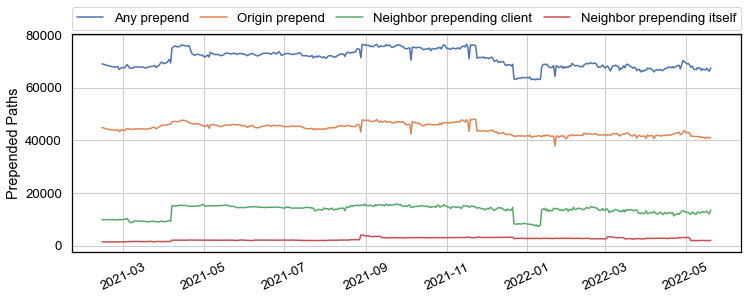

In [19]:
#graph_who_is_prepending('linx', 'ban', 100)
graph_who_is_prepending('linx', 'best', 0)

### Generate {fig:prepend-linx}

Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//amsix_best_0_prepend.csv]
Figure saved at ./FIG/amsix_best_prepend_vs_notprepend.pdf


<Figure size 864x288 with 0 Axes>

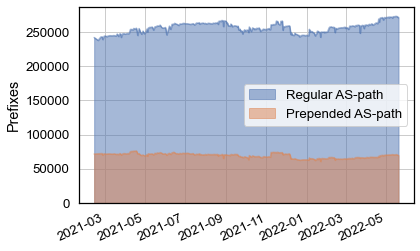

In [20]:
graph_prepend_noprepend_best('amsix', 'best', 0, True, 'best')

Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//linx_best_0_prepend.csv]
Figure saved at ./FIG/linx_best_prepend_vs_notprepend.pdf


<Figure size 864x288 with 0 Axes>

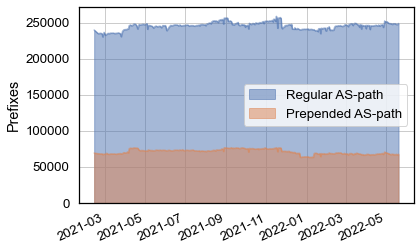

In [39]:
graph_prepend_noprepend_best('linx', 'best', 0, True, 'best')

### Generate {fig:amsix_as6939}

Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//amsix_best_0_prepend.csv]
Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//amsix_6939_0_prepend.csv]
Figure saved at ./FIG/amsix_as6939.pdf


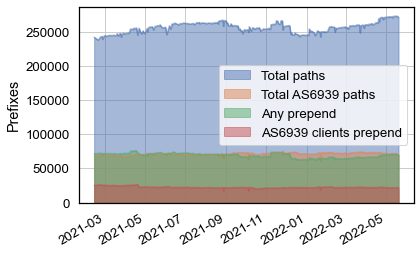

In [22]:
gen_6939_graphs('amsix', 0, labely=True, legend='best')

### Generate {fig:spoixbr_as6939}

Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//six_best_0_prepend.csv]
Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//six_6939_0_prepend.csv]
Figure saved at ./FIG/six_as6939.pdf


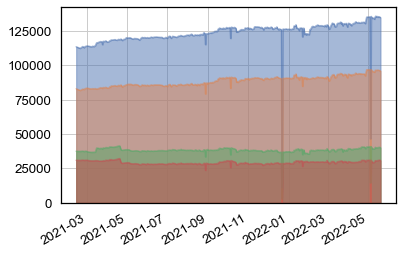

In [23]:
gen_6939_graphs('six', 0, labely=False, legend=False)

# Stop Here if you do not want to generate all 

In [24]:
#raise Exception("STOPPING HERE")

### Generate  ALL {fig:as6939} (appendix) 

In [25]:
# for ixp in ixp_list:
#     print (ixp)
#     gen_6939_graphs(ixp, 0)

In [26]:
# MEAN AS-PATH size from AS6939 on SIX
df=load_ixp('linx', '6939', max_samples=1)
df['as_path_len'].describe()

Loading files for LINX on /Users/bertholdo/tmp/Routing_Tables/
.	Done!
	Step1:Calc as_path_len
	Chosing the best as-path to count prepends...
	Step2:Verifying any_prepend
	Step3:Verifying nei_prepend
	Step4:Verifying origin_prepend


count    88448.000000
mean         4.003075
std          2.269204
min          1.000000
25%          3.000000
50%          3.000000
75%          5.000000
max         29.000000
Name: as_path_len, dtype: float64

### Calculate MEAN/MAX as-path to all IXPS

In [27]:
# MAX/MEAN AS-PATH to all IXPs
# (95% of all registers annoucemtns by one year on IXP is up to 10-as-path-long)
for ixp in ixp_list:
    percentile=0.97
    df=load_ixp(ixp, 'open', max_samples=50)
    print (f" Percentile {percentile*100}% ON {ixp} ==> {df['as_path_len'].quantile(percentile)}")
    #display(df['as_path_len'].describe())

Loading files for AMSIX on /Users/bertholdo/tmp/Routing_Tables/
.........10/352.........20/352.........30/352.........40/352.........50/352	Done!
	Step1:Calc as_path_len
	Chosing the best as-path to count prepends...
	Step2:Verifying any_prepend
	Step3:Verifying nei_prepend
	Step4:Verifying origin_prepend
 Percentile 97.0% ON amsix ==> 10.0
Loading files for SPOIXBR on /Users/bertholdo/tmp/Routing_Tables/
.........10/307.........20/307.........30/307.........40/307.........50/307	Done!
	Step1:Calc as_path_len
	Chosing the best as-path to count prepends...
	Step2:Verifying any_prepend
	Step3:Verifying nei_prepend
	Step4:Verifying origin_prepend
 Percentile 97.0% ON spoixbr ==> 10.0
Loading files for SIX on /Users/bertholdo/tmp/Routing_Tables/
.........10/356.........20/356.........30/356.........40/356.........50/356	Done!
	Step1:Calc as_path_len
	Chosing the best as-path to count prepends...
	Step2:Verifying any_prepend
	Step3:Verifying nei_prepend
	Step4:Verifying origin_prepend
 Perc

### Generate all IXP prepend (best) analisys

In [28]:
# # count IXPs prepends (best)
# ixp='all'
# option='best' #option='ban'
# sample=0
# if ixp=='all':
#     for ixp in ixp_list:
#         graph_who_is_prepending(ixp,option, sample)
#         graph_pre`pend_noprepend_best(ixp, option,sample)        
# else:
#     graph_who_is_prepending(ixp,option,sample)
#     graph_prepend_noprepend_best(ixp, option,sample)

### Generate AS3333 view

Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//rrc00-as3333_best_0_prepend.csv]
Figure saved at ./FIG/rrc00-as3333_best_prepend_vs_notprepend.pdf


<Figure size 864x288 with 0 Axes>

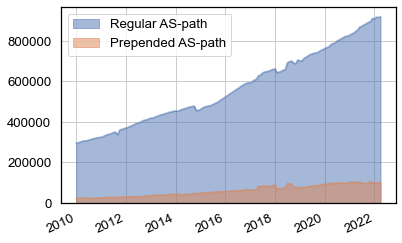

In [29]:
graph_prepend_noprepend_best('rrc00-as3333', 'best', 0, labely=False, legend='best')#, , legend='center right')

### Generate Table prepend {tab:prepend}

In [30]:
gen_table_prepend()

\begin{table}
\centering
\caption{Percentual analisys of IXP's prepended paths}
\label{tab:ixp-prepend}
\begin{tabular}{lrrrrr}
\toprule
ixp & any\_prep & nei\_prep & origin\_prep & nei\_client & nei\_origin \\
\midrule
amsix & 26.52 & 20.52 & 17.86 & 16.57 & 8.52 \\
linx & 28.91 & 23.43 & 17.94 & 19.74 & 9.21 \\
poaixbr & 31.00 & 9.56 & 14.39 & 8.79 & 3.25 \\
six & 30.19 & 11.96 & 22.10 & 5.22 & 24.29 \\
spoixbr & 26.15 & 8.72 & 18.43 & 5.84 & 6.41 \\
\hline
\end{tabular}
\end{table}



,ixp,any\_prep,nei\_prep,origin\_prep,nei\_client,nei\_origin
0,amsix,26.52,20.515,17.86,16.57,8.52
1,linx,28.91,23.429,17.94,19.74,9.21
2,poaixbr,31.00,9.560,14.39,8.79,3.25
3,six,30.19,11.960,22.10,5.22,24.29
4,spoixbr,26.15,8.716,18.43,5.84,6.41


,ixp,any\_prep,nei\_prep,origin\_prep,nei\_client,nei\_origin
0,amsix,26.52,20.515,17.86,16.57,8.52
1,linx,28.91,23.429,17.94,19.74,9.21
2,poaixbr,31.00,9.560,14.39,8.79,3.25
3,six,30.19,11.960,22.10,5.22,24.29
4,spoixbr,26.15,8.716,18.43,5.84,6.41


# Are ISPs  "depreferring" the IXP path?

# Test area

### Mind SIX routing table issue in APR-MAI/2022  (investigate if needed)

In [31]:
# SIX routing table issue in APR-MAI/2022  (investigate if needed)
# Same POAIXBR in dez/2021
# dsum=load_prepend_summary()
# df=dsum.copy()
# 
# df['sum']=df['perc_nei_prep_client']+df['perc_nei_prep_origin']
# df['dif']=df['perc_any_prep_path']-df['sum']
# df['a-o']=df['any_prep_path']-df['origin_prep']
# df['zero']=df['any_prep_path']-df['origin_prep']-df['sum']
# 
# df[df['dif']<-5]['dif'].describe()
# 
# df['dif'].describe()
# 
# df[df['dif']<-5]
#
# df[df['zero']<0]

# Compare GLOBAL prefixes from AS3333 and AMSIX for ONE DAY 
 <pre>
 Takeaway: When we compare individual prefixes annouced on IXP with the global routing table view from AS3333
 we notice more than 97% of direct connected AMSIX customers provides an equal (~71.46%) of shortest (~20.69%) 
 as-path
 When we look at all prefixes annouced to the IXP we got equal(64.75%), and shortest(20.69%)
</pre>

In [32]:
def xx3_global_prefixes():
    ixp=BGP_DATA+'2022-04-01_rtable_ALICERS_amsix.csv.gz'
    #ixp=BGP_DATA+'2022-04-01_rtable_BIRD_spoixbr.csv.gz'
    
    as3333=BGP_DATA+'2022-04-01_rtable_GLOBAL_rrc00-as3333.csv.gz'
    
    # Load global and IXP
    ix_df=pd.read_csv(ixp)
    global_df=pd.read_csv(as3333)
    
    ix_name=ixp.split('_')[4].split('.')[0]
    
    # Count prepends 
    ix_df['any_prepend']=ix_df['AS_PATH'].parallel_apply(tem_prepend)
    ix_df['as_path_len']=ix_df['AS_PATH'].parallel_apply(lambda x: len(str(x).split()))
    global_df['any_prepend']=global_df['AS_PATH'].parallel_apply(tem_prepend)
    global_df['as_path_len']=global_df['AS_PATH'].parallel_apply(lambda x: len(str(x).split()))
    print (f'routes amsix[{len(ix_df)}]  global[{len(global_df)}]')
    
    # Filter prepended networks on ixp
    lnet=ix_df[ix_df['any_prepend']==True]['NETWORK'].to_list()
    # count num of ixp prepended but not global prepended
    df=global_df[global_df['NETWORK'].isin(lnet)]
    numP = len(df[df['any_prepend']==True])
    numNP = len(df[df['any_prepend']==False])
    print(f'ixp prefix Prepended also on global {numP}   Not prepended on global {numNP}')
    
    # Compare IXP and global by as-path size on same prefix
    
    # rename ix columns to merge
    cix=ix_df.copy()
    cix.columns = 'ix_' + cix.columns.values
    
    # join global and ixp as-paths
    df=pd.merge(global_df[['NETWORK', 'AS_PATH', 'any_prepend', 'as_path_len']], 
                      cix[['ix_NETWORK','ix_AS_PATH','ix_any_prepend','ix_as_path_len','ix_as_neigh', 'ix_as_origin']], how="inner", left_on = 'NETWORK', right_on = 'ix_NETWORK')
    df=df[~df.isnull().any(1)]  #ignoring routes originated on AS3333(just 6 cases) global_df[global_df.isnull().any(1)]
    
    
    # path len difference as3333 vs. IXP
    total=  len(df)
    equal=  df[df['as_path_len']==df['ix_as_path_len']]['NETWORK'].count()
    bigger= df[(df['as_path_len']>df['ix_as_path_len'])]['NETWORK'].count()
    smaller=df[(df['as_path_len']<df['ix_as_path_len'])]['NETWORK'].count()
    #print (f'AS3333 have \t{equal} equal as-paths length than {ix_name.upper()}, \n\t\t{bigger} bigger, and \n\t\t{smaller} smaller lenght')
    print ('\n=== Path len difference Global and IXP view ===')
    print ('AS3333 have {} paths. \n\t{} {}% equal as-path length than {}, \n\t{} {}% IXP is shortest, and \n\t{} {}% IXP is longer '.format(
        total, equal, round(equal/total*100,2), {ix_name.upper()},bigger, round(bigger/total*100,2), smaller, round(smaller/total*100,2) ))
    
    # path len difference as3333 vs. IXP - JUST DIRECTED CONNECTED AS-prefixes
    # Obviously directed connected is the best path for >90% or equal >5%
    total= len(df[(df['ix_as_neigh']==df['ix_as_origin'])])
    equal=  df[(df['as_path_len']==df['ix_as_path_len']) & (df['ix_as_neigh']==df['ix_as_origin'])]['NETWORK'].count()
    bigger= df[(df['as_path_len']>df['ix_as_path_len'])  & (df['ix_as_neigh']==df['ix_as_origin'])]['NETWORK'].count()
    smaller=df[(df['as_path_len']<df['ix_as_path_len'])  & (df['ix_as_neigh']==df['ix_as_origin'])]['NETWORK'].count()
    print ('\n=== Path len difference of Global and directed connected AS-prefixes ===')
    print ('AS3333 have {} paths. \n\t{} {}% equal as-path length than {}, \n\t{} {} IXP is shortest, and \n\t{} {} IXP is longer '.format(
        total, equal, round(equal/total*100,2), {ix_name.upper()},bigger, round(bigger/total*100,2), smaller, round(smaller/total*100,2) ))

In [33]:
xx3_global_prefixes

<function __main__.xx3_global_prefixes()>

In [34]:
#df=pd.read_csv('/Users/bertholdo/tmp/Routing_Tables/2022-05-05_rtable_ALICE_linx.csv.gz')
#df.groupby('as_neigh').count().sort_values('NETWORK', ascending=False)

# TEST

In [35]:
df=load_prepend_summary(['amsix', 'spoixbr', 'six', 'linx', 'poaixbr'],'best',0)
df.head(2)

,day,ixp,tot_paths,any_prep_path,origin_prep,tot_origin_customer,nei_prep_all,nei_prep_origin,nei_prep_client,perc_any_prep_path,perc_origin_prep,perc_origin_customer,perc_nei_prep_origin,perc_nei_prep_client
0,2022-05-20,spoixbr,174206,45007,31090,19123,4119,1241,2878,25.84,17.85,10.98,6.49,6.39
1,2022-05-20,six,134783,39960,28550,10633,4627,2613,2014,29.65,21.18,7.89,24.57,5.04


In [36]:
df.columns

Index(['day', 'ixp', 'tot_paths', 'any_prep_path', 'origin_prep',
       'tot_origin_customer', 'nei_prep_all', 'nei_prep_origin',
       'nei_prep_client', 'perc_any_prep_path', 'perc_origin_prep',
       'perc_origin_customer', 'perc_nei_prep_origin', 'perc_nei_prep_client'],
      dtype='object')

,day,tot_paths,any_prep_path,origin_prep,tot_origin_customer,nei_prep_all,nei_prep_origin
3,2022-05-20,248863,67567,41102,28511,15477,1957
8,2022-05-19,247844,66286,40837,28393,14043,1946


<AxesSubplot:xlabel='day'>

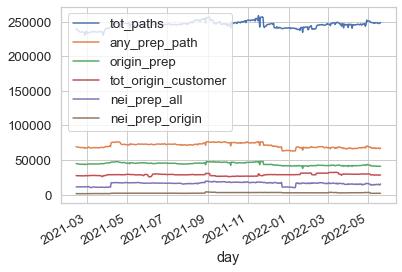

In [37]:
ixp='linx'
df=load_prepend_summary(['amsix', 'spoixbr', 'six', 'linx', 'poaixbr'],'best',0)
df=df[df['ixp']==ixp]
df = df[['day', 'tot_paths', 'any_prep_path', 'origin_prep',
       'tot_origin_customer', 'nei_prep_all', 'nei_prep_origin']]
df['day']=pd.to_datetime(df['day'])
display(df.head(2))
df.plot.line(x='day')

amsix
Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//amsix_best_0_prepend.csv]
Figure saved at ./FIG/amsix_best_who_is_prepending.pdf


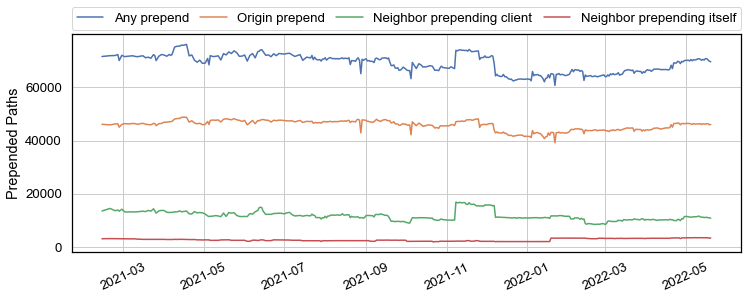

spoixbr
Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//spoixbr_best_0_prepend.csv]
Figure saved at ./FIG/spoixbr_best_who_is_prepending.pdf


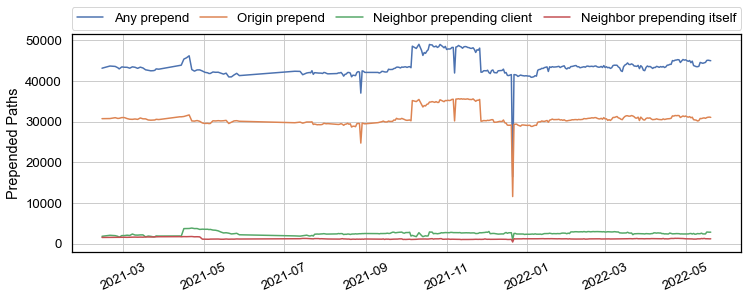

six
Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//six_best_0_prepend.csv]
Figure saved at ./FIG/six_best_who_is_prepending.pdf


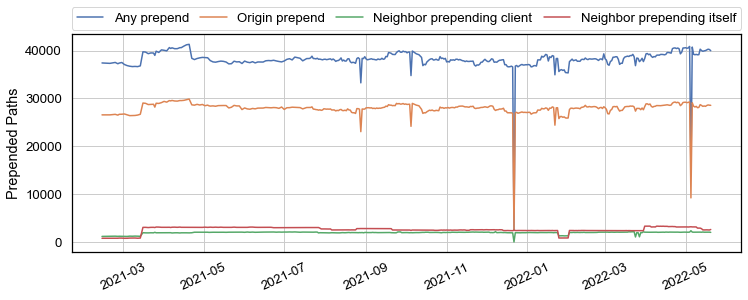

linx
Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//linx_best_0_prepend.csv]
Figure saved at ./FIG/linx_best_who_is_prepending.pdf


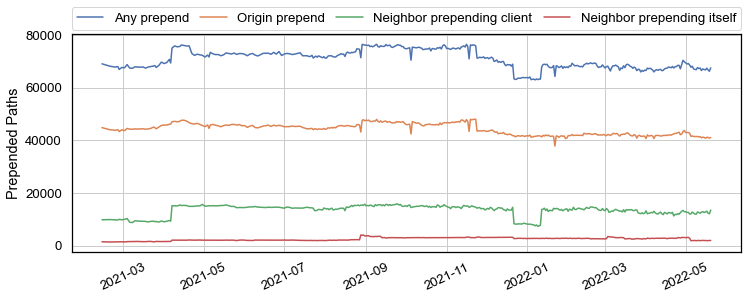

poaixbr
Reading dataframe from file [/Users/bertholdo/ut_gitlab/asy_pathsize/dataset//poaixbr_best_0_prepend.csv]
Figure saved at ./FIG/poaixbr_best_who_is_prepending.pdf


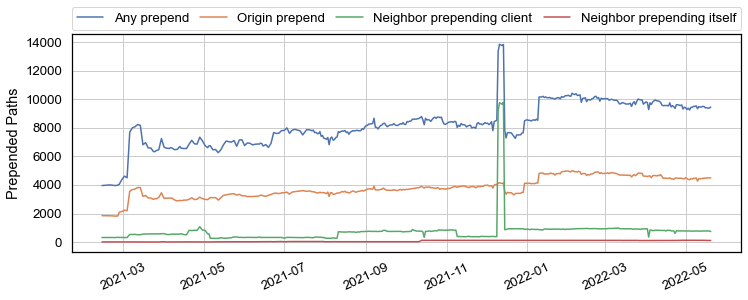

In [38]:
# Generate WHOIS PREPENDIND on ALL IXPS
for ixp in ixp_list:
    print (ixp)
    graph_who_is_prepending(ixp, 'best', 0)
